In [19]:
import json
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

from diskit.components.layer import *
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.compiler import transpile

from diskit_updated.circuit_remapper import *
from ionq.compile_native import compile_to_ionq_native_gates

from matplotlib.ticker import ScalarFormatter

class ScalarFormatterClass(ScalarFormatter):
   def _set_format(self):
      self.format = "%1.2f"
yScalarFormatter = ScalarFormatterClass(useMathText=True)
yScalarFormatter.set_powerlimits((0,0))

In [2]:
with open("error_datasheets/Triangulum_SpinQ_3qubits.json", 'r') as f:
    spinq_3q_datasheet = json.load(f)

with open("error_datasheets/Harmony_IonQ_11qubits.json", 'r') as f:
    ionq_11q_datasheet = json.load(f)
with open("error_datasheets/Aria1_IonQ_25qubits.json", 'r') as f:
    ionq_25q_datasheet = json.load(f)
with open("error_datasheets/Forte1_IonQ_36qubits.json", 'r') as f:
    ionq_36q_datasheet = json.load(f)

with open("error_datasheets/IBM_Kyiv_127qubits.json", 'r') as f:
    ibm_kyiv_127q_datasheet = json.load(f)

In [3]:
# GENERAL GATES
measure_gate = 'measure'
reset_gate = 'reset'

# 1. IONQ -> Only valid gates are:
#   - GPI: Puerta IonQ GPi
#   - GPI2: Puerta IonQ GPi2.
#   - MS: Puerta IonQ de Mølmer-Sørenson.

#GPI = Rz(2ϕ)X
#GPI2 = Rz(ϕ)Rx(π/2)Rz(−ϕ)
ionq_predecomposition_gates = ["id", "rx", "ry", "rz", "cx"]
ionq_valid_1qgates = ['gpi', 'gpi2']
ionq_valid_2qgates = ['ms']
ionq_valid_gates = ionq_valid_1qgates + ionq_valid_2qgates

# 2. IBMQ Kyiv -> ECR, ID, RZ, SX, X
ibmq_valid_1qgates = ["id", "rz", "sx", "x"]
ibmq_valid_2qgates = ["ecr"]
ibmq_valid_gates = ibmq_valid_1qgates + ibmq_valid_2qgates

# 3. SpinQ -> H, X, Y, Z, SX, SY, SZ, RX, RY, RZ, T, TDG, S, SDG, CX, CY, CZ
spinq_valid_1qgates = ["id", "h", "x", "sx", "y", "z", "rx", "ry", "rz", "t", "tdg", "s", "sdg"]
spinq_valid_2qgates = ["cx", "cy", "cz"]
spinq_valid_gates = spinq_valid_1qgates + spinq_valid_2qgates

# CIRCUIT TO SIMULATE

In [4]:
from qiskit.circuit.library import QFT

def initialize_circuit(qregs = None, n_qubits = None):
    if qregs is None:
        return QuantumCircuit(n_qubits)
    
    qregs_list = qregs.values()
    return QuantumCircuit(*qregs_list)


def get_circuit_max14qubits(qregs = None, n_qubits = None):
    q_circuit = initialize_circuit(qregs, n_qubits)

    q_circuit.append(QFT(14).to_gate(), [i for i in range(14)])
    
    return q_circuit


def get_circuit_max30qubits(qregs = None, n_qubits = None):
    q_circuit = initialize_circuit(qregs, n_qubits)

    q_circuit.append(QFT(30).to_gate(), [i for i in range(30)])

    return q_circuit


def get_circuit_max120qubits(qregs = None, n_qubits = None):
    q_circuit = initialize_circuit(qregs, n_qubits)

    q_circuit.append(QFT(120).to_gate(), [i for i in range(120)])
    
    return q_circuit

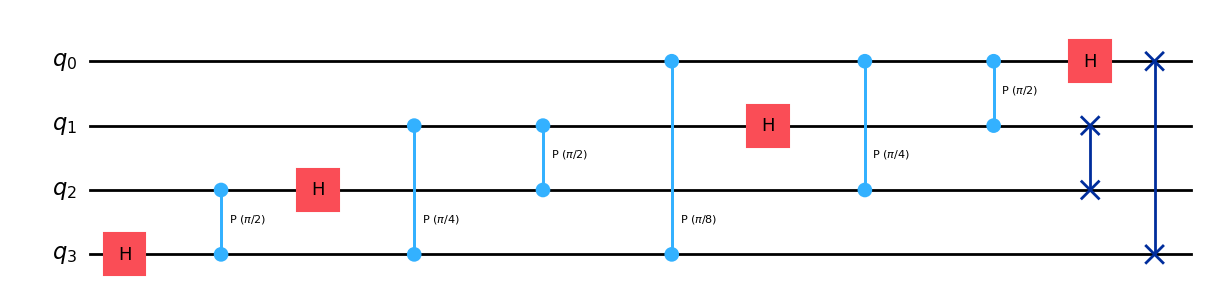

In [98]:
QFT(4).decompose().draw(output="mpl")

# DISTRIBUTED UTILITIES

In [6]:
def create_distributed_topology(n_nodes, qubits_per_qnode):
    circuit_topo = Topology()
    circuit_topo.create_qmap(n_nodes, [qubits_per_qnode for _ in range(n_nodes)], "qnode")

    qregs = {}

    for qpu in circuit_topo.qmap:
        reg = circuit_topo.qmap[qpu][0]._register
        qregs[reg.name] = reg
    for qpu in circuit_topo.emap:
        reg = circuit_topo.emap[qpu]._register
        qregs[reg.name] = reg
    
    return circuit_topo, qregs

In [7]:
def remap_circuit(qc, circuit_topo, qregs, decompose_list=None, measure=False):
    remapper = CircuitRemapper(circuit_topo)
    if decompose_list is None:
        dist_circ, total_non_local_ops = remapper.remap_circuit(qc, return_non_local_ops=True)
    else:
        dist_circ, total_non_local_ops = remapper.remap_circuit(qc, decompose=True, decompose_list=decompose_list, return_non_local_ops=True)

    print(f"Total non-local operations: {total_non_local_ops}")
    
    if measure:
        measure_reg_q0 = ClassicalRegister(len(qregs['qnode0']), name="measure_qnode0")
        measure_reg_q1 = ClassicalRegister(len(qregs['qnode1']), name="measure_qnode1")
        dist_circ.add_register(measure_reg_q0)
        dist_circ.add_register(measure_reg_q1)
        #dist_circ.barrier()
        dist_circ.measure(qregs['qnode0'], measure_reg_q0)
        dist_circ.measure(qregs['qnode1'], measure_reg_q1)

    return dist_circ

# ANALISIS CIRCUITOS

- Calculo de la fidelidad total

In [8]:
import math

def calculate_total_fidelity(
    count_operations: OrderedDict, 
    op_list_1q: list[str], 
    op_list_2q: list[str],
    config_json: dict[str, object]
) -> float:
    
    #total_error = 0
    total_fidelity = 1.0
    fidelity_config = config_json["fidelity"]

    for op_1q in op_list_1q:
        if op_1q in count_operations:
            #total_error += count_operations[op_1q] * (1 - fidelity_config['1Q']['mean'])
            total_fidelity *= math.pow(fidelity_config['1Q']['mean'], count_operations[op_1q])

    for op_2q in op_list_2q:
        if op_2q in count_operations:
            #total_error += count_operations[op_2q] * (1 - fidelity_config['2Q']['mean'])
            total_fidelity *= math.pow(fidelity_config['2Q']['mean'], count_operations[op_2q])

    if measure_gate in count_operations:
        #total_error += count_operations[measure_gate] * (1 - fidelity_config['readout']['mean'])
        total_fidelity *= math.pow(fidelity_config['readout']['mean'], count_operations[measure_gate])

    #return 1 - total_error
    return total_fidelity

- Benchmark de diferentes máquinas y algoritmos:

In [9]:
from itertools import permutations

def compute_metrics(
    count_operations: OrderedDict,
    machine_type_config: dict[str, object],

):
    if machine_type_config["machine"] == "ionq":
        fidelity = calculate_total_fidelity(count_operations, ionq_valid_1qgates, 
                                            ionq_valid_2qgates, machine_type_config)
    elif machine_type_config["machine"] == "ibmq":
        fidelity = calculate_total_fidelity(count_operations, ibmq_valid_1qgates, 
                                            ibmq_valid_2qgates, machine_type_config)
    elif machine_type_config["machine"] == "spinq":
        fidelity = calculate_total_fidelity(count_operations, ibmq_valid_1qgates, 
                                            ibmq_valid_2qgates, machine_type_config)
    
    return fidelity


def benchmark_distributed_execution(
    benchmark_machine_list: list[tuple[dict[str, object], int, int]],
    circuit_function,
    saved_counts: list[OrderedDict] = None
):
    dist_circuits = []
    output_circuits = []

    qubits_list = []
    fidelity_list = []
    duration_list = []

    for idx, (machine_type_config, n_qnodes, qubits_per_qnode) in enumerate(benchmark_machine_list):
        if saved_counts is not None and idx < len(saved_counts):
            fidelity = compute_metrics(saved_counts[idx], machine_type_config)
        else:
            print(f"* Starting analysis with {machine_type_config['machine']} - {n_qnodes} qnodes - {qubits_per_qnode} qubits per qnode:")
            if machine_type_config["machine"] == "ionq":
                decompose_list = ionq_predecomposition_gates
            else:
                decompose_list = ibmq_valid_gates

            if n_qnodes == 1:
                dist_circuit = circuit_function(n_qubits=qubits_per_qnode)
            else:
                circuit_topo, qregs = create_distributed_topology(n_nodes=n_qnodes, qubits_per_qnode=qubits_per_qnode)
                initial_circuit = circuit_function(qregs=qregs)

                # Es necesario antes de remapear el circuito transpilarlo a puertas basicas
                # (para descomponer puertas de más de 2 qubits)
                print("\t- Initializing distributed mapping...")
                initial_circuit = transpile(initial_circuit, basis_gates=decompose_list)
                # Remapeamos el circuito a formato distribuido
                print("\t- Remapping circuit...")
                dist_circuit = remap_circuit(qc=initial_circuit, circuit_topo=circuit_topo, qregs=qregs)
            
            print("\t-Executing final compilation...")
            if machine_type_config["machine"] == "ionq":
                output_ionq_circuit = compile_to_ionq_native_gates(dist_circuit, check=False)

                ionq_instruction_durations = (
                    [(gate, qubit, machine_type_config["timing (us)"]['1Q']/1000000, 's') for qubit in range(len(dist_circuit.qubits)) for gate in ionq_valid_1qgates] +
                    [(gate, qubits, machine_type_config["timing (us)"]['2Q']/1000000, 's') for qubits in permutations(range(len(dist_circuit.qubits)), 2) for gate in ionq_valid_2qgates] +
                    [('measure', qubit, machine_type_config["timing (us)"]['readout']/1000000, 's') for qubit in range(len(dist_circuit.qubits))] +
                    [('reset', qubit, machine_type_config["timing (us)"]['reset']/1000000, 's') for qubit in range(len(dist_circuit.qubits))]
                )
                output_circuit = transpile(output_ionq_circuit, basis_gates=ionq_valid_gates,
                                           coupling_map=[list(qubits) for qubits in permutations(range(len(dist_circuit.qubits)), 2)],
                                           initial_layout=[qubit for qubit in range(len(dist_circuit.qubits))],
                                           scheduling_method="asap", instruction_durations=ionq_instruction_durations)
            elif machine_type_config["machine"] == "ibmq":
                ibmq_instruction_durations = (
                    [(gate, qubit, machine_type_config["timing (us)"]['1Q']/1000000, 's') for qubit in range(len(dist_circuit.qubits)) for gate in ibmq_valid_1qgates] +
                    [(gate, qubits, machine_type_config["timing (us)"]['2Q']/1000000, 's') for qubits in permutations(range(len(dist_circuit.qubits)), 2) for gate in ibmq_valid_2qgates] +
                    [('measure', qubit, machine_type_config["timing (us)"]['readout']/1000000, 's') for qubit in range(len(dist_circuit.qubits))] +
                    [('reset', qubit, machine_type_config["timing (us)"]['reset']/1000000, 's') for qubit in range(len(dist_circuit.qubits))]
                )
                output_circuit = transpile(dist_circuit, basis_gates=ibmq_valid_gates,
                                           coupling_map=[list(qubits) for qubits in permutations(range(len(dist_circuit.qubits)), 2)],
                                           initial_layout=[qubit for qubit in range(len(dist_circuit.qubits))],
                                           scheduling_method="asap", instruction_durations=ibmq_instruction_durations)
                
            elif machine_type_config["machine"] == "spinq":
                spinq_instruction_durations = (
                    [(gate, qubit, machine_type_config["timing (us)"]['1Q']/1000000, 's') for qubit in range(len(dist_circuit.qubits)) for gate in spinq_valid_1qgates] +
                    [(gate, qubits, machine_type_config["timing (us)"]['2Q']/1000000, 's') for qubits in permutations(range(len(dist_circuit.qubits)), 2) for gate in spinq_valid_2qgates] +
                    [('measure', qubit, machine_type_config["timing (us)"]['readout']/1000000, 's') for qubit in range(len(dist_circuit.qubits))] +
                    [('reset', qubit, machine_type_config["timing (us)"]['reset']/1000000, 's') for qubit in range(len(dist_circuit.qubits))]
                )
                output_circuit = transpile(dist_circuit, basis_gates=spinq_valid_gates,
                                           coupling_map=[list(qubits) for qubits in permutations(range(len(dist_circuit.qubits)), 2)],
                                           initial_layout=[qubit for qubit in range(len(dist_circuit.qubits))],
                                           scheduling_method="asap", instruction_durations=spinq_instruction_durations)

            print(f"Duration: {output_circuit.duration}")
            
            duration_list.append(output_circuit.duration)
            dist_circuits.append(dist_circuit)
            output_circuits.append(output_circuit)
            count_operations = output_circuit.count_ops()
        
            fidelity = compute_metrics(count_operations, machine_type_config)
        
        fidelity_list.append(fidelity)
        qubits_list.append(qubits_per_qnode)
            
    return dist_circuits, output_circuits, duration_list, qubits_list, fidelity_list

# EXECUTION SPINQ AND IONQ MACHINES WITH 14 QUBIT ALGORITHM

In [10]:
dist_circuits_14q, output_circuits_14q, duration_list, qubits_list, fidelity_list = benchmark_distributed_execution(
    benchmark_machine_list=[
        (spinq_3q_datasheet, 7, 2), 
        (ionq_11q_datasheet, 2, 10), 
        (ionq_25q_datasheet, 1, 24)
    ],
    circuit_function=get_circuit_max14qubits,
)

with open("output/14q_qft.json", "w") as outfile:
    json.dump({
        "duration": duration_list,
        "qubits_per_qnode": qubits_list,
        "fidelity": fidelity_list
    }, outfile)

* Starting analysis with spinq - 7 qnodes - 2 qubits per qnode:
	- Initializing distributed mapping...
	- Remapping circuit...
Total non-local operations: 186
	-Executing final compilation...
Duration: 0.06904400000000017
* Starting analysis with ionq - 2 qnodes - 10 qubits per qnode:
	- Initializing distributed mapping...
	- Remapping circuit...
Total non-local operations: 92
	-Executing final compilation...
Duration: 0.06108000000000066
* Starting analysis with ionq - 1 qnodes - 24 qubits per qnode:
	-Executing final compilation...
Duration: 0.0498900000000002


In [22]:
fidelity_list[0]*(0.86**186)

8.656432218695849e-17

C:\Users\danie\AppData\Local\Temp\ipykernel_4464\359625885.py:63: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(fidelity_list[0]*(0.86**186)-0.01, 0.04)


(2.032685095801145e-17, 0.04)

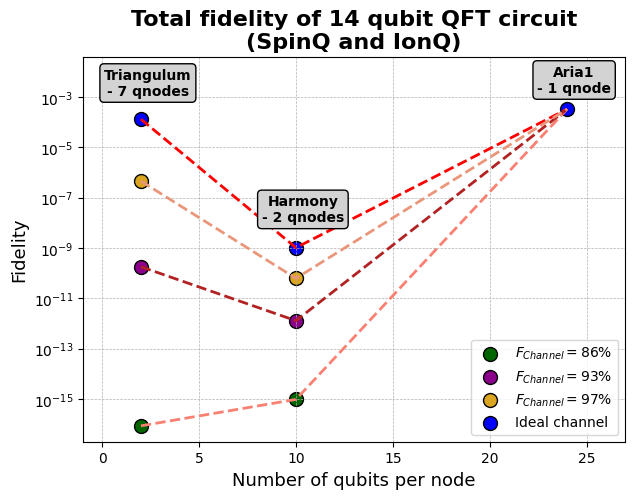

In [93]:
labels = ["Triangulum\n- 7 qnodes", "Harmony\n- 2 qnodes", "Aria1\n- 1 qnode"]

with open("output/14q_qft.json", "r") as inputfile:
    json_object = json.load(inputfile)
    duration_list = json_object["duration"]
    qubits_list = json_object["qubits_per_qnode"]
    fidelity_list = json_object["fidelity"]

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(7, 5))

f_86 = [fidelity_list[0]*(0.86**186), fidelity_list[1]*(0.86**92), fidelity_list[2]]
f_93 = [fidelity_list[0]*(0.93**186), fidelity_list[1]*(0.93**92), fidelity_list[2]]
f_97 = [fidelity_list[0]*(0.97**186), fidelity_list[1]*(0.97**92), fidelity_list[2]]

# Calcular la línea de tendencia
coefficients = np.polyfit(qubits_list, fidelity_list, 2)
trendline = np.poly1d(coefficients)

coefficients_86 = np.polyfit(qubits_list, f_86, 2)
trendline_86 = np.poly1d(coefficients_86)

coefficients_93 = np.polyfit(qubits_list, f_93, 2)
trendline_93 = np.poly1d(coefficients_93)

coefficients_97 = np.polyfit(qubits_list, f_97, 2)
trendline_97 = np.poly1d(coefficients_97)

# Configuración del gráfico
ax.scatter(qubits_list[:-1], f_86[:-1], color='darkgreen', s=100, edgecolors='k', label=r'$F_{Channel} = 86\%$')
ax.scatter(qubits_list[:-1], f_93[:-1], color='darkmagenta', s=100, edgecolors='k', label=r'$F_{Channel} = 93\%$')
ax.scatter(qubits_list[:-1], f_97[:-1], color='goldenrod', s=100, edgecolors='k', label=r'$F_{Channel} = 97\%$')
ax.scatter(qubits_list, fidelity_list, color='blue', s=100, edgecolors='k', label='Ideal channel')
ax.plot(qubits_list, trendline(qubits_list), color='red', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_86(qubits_list), color='salmon', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_93(qubits_list), color='firebrick', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_97(qubits_list), color='darksalmon', linestyle='--', linewidth=2)

# Añadir etiquetas a los puntos
for i, txt in enumerate(labels):
    if i == 1:
        offset = 0.000000005
    else:
        offset = 0.0005
    ax.annotate(txt, (qubits_list[i], fidelity_list[i]+offset), textcoords="offset points", xytext=(5,5), ha='center',
                fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))

# Títulos y etiquetas
ax.set_title('Total fidelity of 14 qubit QFT circuit\n(SpinQ and IonQ)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of qubits per node', fontsize=13)
ax.set_ylabel('Fidelity', fontsize=13)

# Líneas de cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

# Get the x, y limits
xmin, xmax = min(qubits_list), max(qubits_list)
ymin, ymax = min(fidelity_list), max(fidelity_list)
ax.yaxis.set_major_formatter(yScalarFormatter)
ax.set_yscale('log')
plt.xlim(xmin-3, xmax+3)
plt.ylim(fidelity_list[0]*(0.86**186)-0.01, 0.04)
#plt.ylim(ymin-0.010, ymax + 0.045)

(0.0489323000000002, 0.07441710000000018)

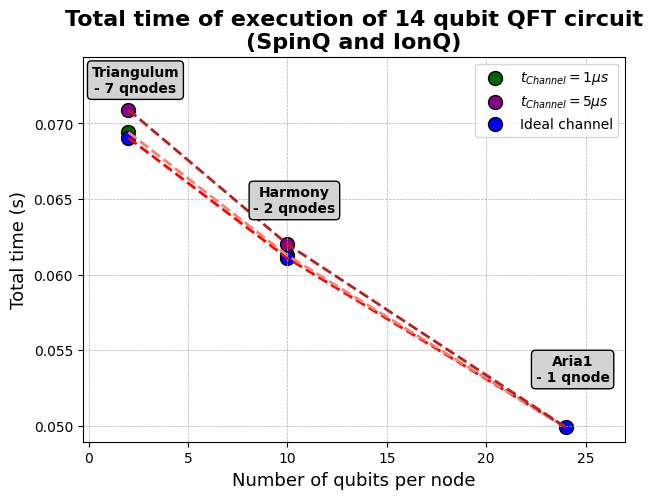

In [94]:
labels = ["Triangulum\n- 7 qnodes", "Harmony\n- 2 qnodes", "Aria1\n- 1 qnode"]
# Get the x, y limits
xmin, xmax = min(qubits_list), max(qubits_list)
ymin, ymax = min(duration_list), max(duration_list)
range_values_y = ymax - ymin

f_min = [duration_list[0]+(1e-6*186*2), duration_list[1]+(1e-6*92*2), duration_list[2]]
f_max = [duration_list[0]+(5e-6*186*2), duration_list[1]+(5e-6*92*2), duration_list[2]]

coefficients_min = np.polyfit(qubits_list, f_min, 2)
trendline_min = np.poly1d(coefficients_min)

coefficients_max = np.polyfit(qubits_list, f_max, 2)
trendline_max = np.poly1d(coefficients_max)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(7, 5))

# Calcular la línea de tendencia
coefficients = np.polyfit(qubits_list, duration_list, 2)
trendline = np.poly1d(coefficients)

# Configuración del gráfico
ax.scatter(qubits_list[:-1], f_min[:-1], color='darkgreen', s=100, edgecolors='k', label=r'$t_{Channel} = 1µs$')
ax.scatter(qubits_list[:-1], f_max[:-1], color='darkmagenta', s=100, edgecolors='k', label=r'$t_{Channel} = 5µs$')
ax.scatter(qubits_list, duration_list, color='blue', s=100, edgecolors='k', label='Ideal channel')
ax.plot(qubits_list, trendline(qubits_list), color='red', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_min(qubits_list), color='salmon', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_max(qubits_list), color='firebrick', linestyle='--', linewidth=2)

# Añadir etiquetas a los puntos
for i, txt in enumerate(labels):
    ax.annotate(txt, (qubits_list[i], duration_list[i] + 0.0017 + range_values_y * 0.045), textcoords="offset points", xytext=(5,5), ha='center',
                fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))

# Títulos y etiquetas
ax.set_title('Total time of execution of 14 qubit QFT circuit\n(SpinQ and IonQ)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of qubits per node', fontsize=13)
ax.set_ylabel('Total time (s)', fontsize=13)

# Líneas de cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

plt.xlim(xmin-2.3, xmax+3)
plt.ylim(ymin - range_values_y * 0.05, ymax + 0.0025 + range_values_y * 0.15)

# EXECUTION IONQ MACHINES WITH 30 QUBIT ALGORITHM

In [13]:
dist_circuits_30q, output_circuits_30q, duration_list, qubits_list, fidelity_list = benchmark_distributed_execution(
    benchmark_machine_list=[
        (spinq_3q_datasheet, 15, 2),
        (ionq_11q_datasheet, 3, 10), 
        (ionq_25q_datasheet, 2, 24), 
        (ionq_36q_datasheet, 1, 36)
    ],
    circuit_function=get_circuit_max30qubits,
)

with open("output/30q_qft.json", "w") as outfile:
    json.dump({
        "duration": duration_list,
        "qubits_per_qnode": qubits_list,
        "fidelity": fidelity_list
    }, outfile)

* Starting analysis with spinq - 15 qnodes - 2 qubits per qnode:
	- Initializing distributed mapping...
	- Remapping circuit...
Total non-local operations: 882
	-Executing final compilation...
Duration: 0.19412679999999943
* Starting analysis with ionq - 3 qnodes - 10 qubits per qnode:
	- Initializing distributed mapping...
	- Remapping circuit...
Total non-local operations: 630
	-Executing final compilation...
Duration: 0.39481000000002897
* Starting analysis with ionq - 2 qnodes - 24 qubits per qnode:
	- Initializing distributed mapping...
	- Remapping circuit...
Total non-local operations: 306
	-Executing final compilation...
Duration: 0.799255000000003
* Starting analysis with ionq - 1 qnodes - 36 qubits per qnode:
	-Executing final compilation...
Duration: 0.1517100000000001


C:\Users\danie\AppData\Local\Temp\ipykernel_4464\2995447106.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(ymin-1e-49, ymax+1)


(1.5266507507043653e-55, 1.000040319621138)

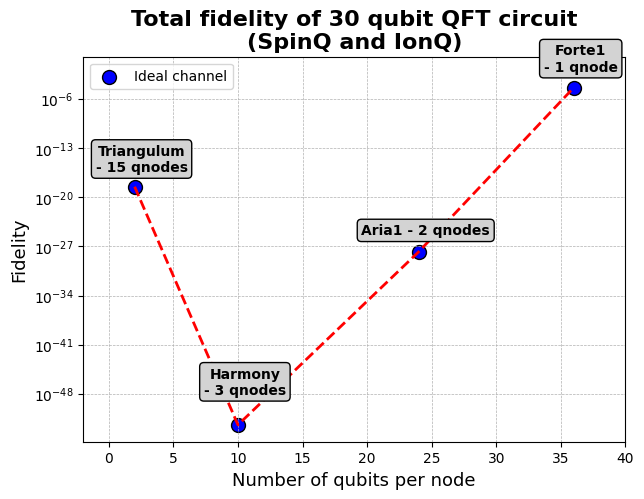

In [95]:
labels = ["Triangulum\n- 15 qnodes", "Harmony\n- 3 qnodes", "Aria1 - 2 qnodes", "Forte1\n- 1 qnode"]

with open("output/30q_qft.json", "r") as inputfile:
    json_object = json.load(inputfile)
    duration_list = json_object["duration"]
    qubits_list = json_object["qubits_per_qnode"]
    fidelity_list = json_object["fidelity"]

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(7, 5))

# Calcular la línea de tendencia
coefficients = np.polyfit(qubits_list, fidelity_list, 3)
trendline = np.poly1d(coefficients)

# Configuración del gráfico
ax.scatter(qubits_list, fidelity_list, color='blue', s=100, edgecolors='k', label='Ideal channel')
ax.plot(qubits_list, fidelity_list, color='red', linestyle='--', linewidth=2)

# Añadir etiquetas a los puntos
ax.annotate(labels[0], (qubits_list[0], fidelity_list[0]+5e-18), textcoords="offset points", xytext=(5,5), ha='center',
            fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))
ax.annotate(labels[1], (qubits_list[1], fidelity_list[1]+1e-49), textcoords="offset points", xytext=(5,5), ha='center',
            fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))
ax.annotate(labels[2], (qubits_list[2], fidelity_list[2]+5e-27), textcoords="offset points", xytext=(5,5), ha='center',
            fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))
ax.annotate(labels[3], (qubits_list[3], fidelity_list[3]+0.001), textcoords="offset points", xytext=(5,5), ha='center',
            fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))

# Títulos y etiquetas
ax.set_title('Total fidelity of 30 qubit QFT circuit\n(SpinQ and IonQ)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of qubits per node', fontsize=13)
ax.set_ylabel('Fidelity', fontsize=13)

# Líneas de cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.yaxis.set_major_formatter(yScalarFormatter)
ax.set_yscale('log')
ax.legend()
# Get the x, y limits
xmin, xmax = min(qubits_list), max(qubits_list)
ymin, ymax = min(fidelity_list), max(fidelity_list)
plt.xlim(xmin-4, xmax+4)
plt.ylim(ymin-1e-49, ymax+1)

(0.11933274999999995, 0.8963867500000035)

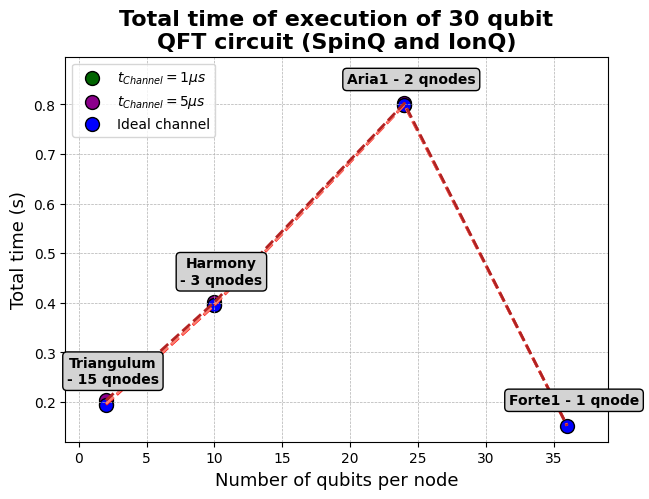

In [96]:
labels = ["Triangulum\n- 15 qnodes", "Harmony\n- 3 qnodes", "Aria1 - 2 qnodes", "Forte1 - 1 qnode"]
# Get the x, y limits
xmin, xmax = min(qubits_list), max(qubits_list)
ymin, ymax = min(duration_list), max(duration_list)
range_values_y = ymax - ymin

f_min = [duration_list[0]+(1e-6*882*2), duration_list[1]+(1e-6*630*2), duration_list[2]+(1e-6*306*2), duration_list[3]]
f_max = [duration_list[0]+(5e-6*882*2), duration_list[1]+(5e-6*630*2), duration_list[2] +(5e-6*306*2), duration_list[3]]

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(7, 5))

# Calcular la línea de tendencia
coefficients = np.polyfit(qubits_list, duration_list, 3)
trendline = np.poly1d(coefficients)

coefficients_min = np.polyfit(qubits_list, f_min, 3)
trendline_min = np.poly1d(coefficients_min)

coefficients_max = np.polyfit(qubits_list, f_max, 3)
trendline_max = np.poly1d(coefficients_max)


# Configuración del gráfico
ax.scatter(qubits_list[:-1], f_min[:-1], color='darkgreen', s=100, edgecolors='k', label=r'$t_{Channel} = 1µs$')
ax.scatter(qubits_list[:-1], f_max[:-1], color='darkmagenta', s=100, edgecolors='k', label=r'$t_{Channel} = 5µs$')
ax.scatter(qubits_list, duration_list, color='blue', s=100, edgecolors='k', label='Ideal channel')
ax.plot(qubits_list, trendline(qubits_list), color='red', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_min(qubits_list), color='salmon', linestyle='--', linewidth=2)
ax.plot(qubits_list, trendline_max(qubits_list), color='firebrick', linestyle='--', linewidth=2)

# Añadir etiquetas a los puntos
for i, txt in enumerate(labels):
    ax.annotate(txt, (qubits_list[i], duration_list[i] + range_values_y * 0.045), textcoords="offset points", xytext=(5,5), ha='center',
                fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))

# Títulos y etiquetas
ax.set_title('Total time of execution of 30 qubit\nQFT circuit (SpinQ and IonQ)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of qubits per node', fontsize=13)
ax.set_ylabel('Total time (s)', fontsize=13)

# Líneas de cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

plt.xlim(xmin-3, xmax+3)
plt.ylim(ymin - range_values_y * 0.05, ymax + range_values_y * 0.15)

#### EXAMPLE OF IONQ COMPILATION

In [16]:
#output_circuits[0].draw(output='mpl')